In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

# from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings("ignore")

from scipy.stats.mstats import winsorize

from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
import os

In [10]:
data = pd.read_csv('data/cosmote.csv',
                   parse_dates=['PERIOD_START_TIME'])
data = data.groupby(
    [pd.Grouper('ID'),
     pd.Grouper(key='PERIOD_START_TIME', freq='D', closed='left')]).sum(numeric_only=False)

In [11]:
# all_ids = list(data.reset_index().ID.unique())
# for iden in all_ids:
#     var = data.loc[iden].NORM_AVG_UL_MAC_CELL_TPUT
#     print(iden)
#     missing = pd.date_range(start = '2021-12-16', end = '2022-08-30').difference(var.index)
#     print(missing, len(missing))

In [12]:
data = data.loc[589]
data['day'] = data.index.day
fill = data.groupby(pd.Grouper(key='day')).mean()

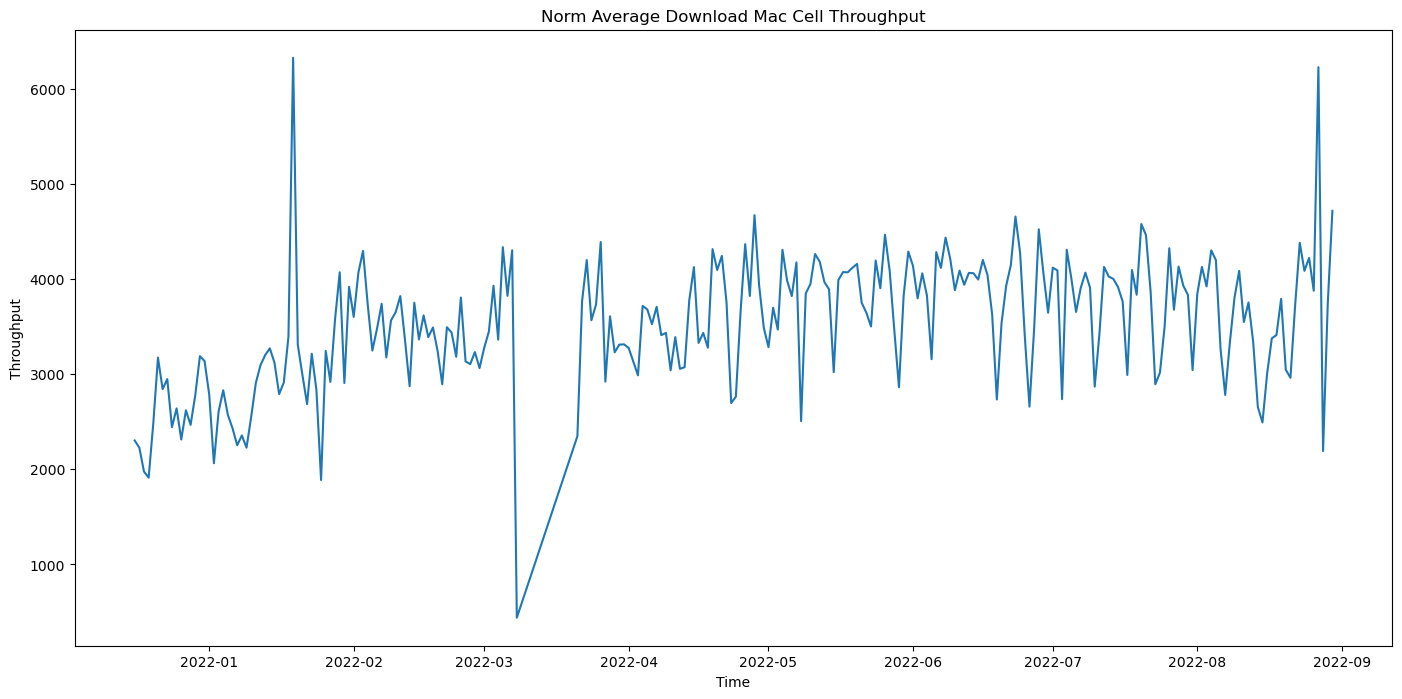

In [13]:
plt.figure(figsize=(17, 8))
plt.plot(data.NORM_AVG_DL_MAC_CELL_TPUT)
plt.title('Norm Average Download Mac Cell Throughput')
plt.ylabel('Throughput')
plt.xlabel('Time')
plt.grid(False)
plt.show()

In [14]:
diff = pd.DataFrame(index=pd.date_range(start = '2021-12-16', end = '2022-08-30').difference(data.index))
diff['day'] = diff.index.day
diff = diff.reset_index()
diff = diff.set_index('day')
diff = diff.join(fill, how='inner')
diff = diff.set_index('index')

In [15]:
data = data.append(diff)
data = data.drop(columns='day')
data = data.sort_index()

In [16]:
var = data.NORM_AVG_DL_MAC_CELL_TPUT

In [ ]:
plt.figure(figsize=(17, 8))
plt.plot(var)
plt.title('Filled Norm Average Download Mac Cell Throughput')
plt.ylabel('Throughput')
plt.xlabel('Time')
plt.grid(False)

plt.figure(figsize=(17, 8))
plt.plot(pd.Series(winsorize(var, limits=[0.01, 0.02]), index=var.index))
plt.title('Winsorized Filled Norm Average Download Mac Cell Throughput')
plt.ylabel('Throughput')
plt.xlabel('Time')
plt.grid(False)
plt.show()

In [13]:
var = pd.Series(winsorize(var, limits=[0.01, 0.02]), index=var.index).loc['2022-03-21':]

In [12]:
# def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

#     rolling_mean = series.rolling(window=window).mean()

#     plt.figure(figsize=(55,8))
#     plt.title('Moving average\n window size = {}'.format(window))
#     plt.plot(rolling_mean, 'g', label='Rolling mean trend')

#     # Plot confidence intervals for smoothed values
#     if plot_intervals:
#         mae = mean_absolute_error(series[window:], rolling_mean[window:])
#         deviation = np.std(series[window:] - rolling_mean[window:])
#         lower_bound = rolling_mean - (mae + scale * deviation)
#         upper_bound = rolling_mean + (mae + scale * deviation)
#         plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
#         plt.plot(lower_bound, 'r--')

#     plt.plot(series[window:], label='Actual values')
#     plt.legend(loc='best')
#     plt.grid(True)


# plot_moving_average(var, 5)

# plot_moving_average(var, 10)

# plot_moving_average(var, 15, plot_intervals=True)

In [13]:
# def exponential_smoothing(series, alpha):

#     result = [series[0]]  # first value is same as series
#     for n in range(1, len(series)):
#         result.append(alpha * series[n] + (1 - alpha) * result[n-1])
#     return result


# def plot_exponential_smoothing(series, alphas):

#     plt.figure(figsize=(17, 8))
#     for alpha in alphas:
#         plt.plot(exponential_smoothing(series, alpha), label="Alpha {}"
#                  .format(alpha))
#     plt.plot(series.values, "c", label="Actual")
#     plt.legend(loc="best")
#     plt.axis('tight')
#     plt.title("Exponential Smoothing")
#     plt.grid(True)


# plot_exponential_smoothing(var, [0.1, 0.3])

In [14]:
# def double_exponential_smoothing(series, alpha, beta):

#     result = [series[0]]
#     for n in range(1, len(series)+1):
#         if n == 1:
#             level, trend = series[0], series[1] - series[0]
#         if n >= len(series):  # forecasting
#             value = result[-1]
#         else:
#             value = series[n]
#         last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
#         trend = beta * (level - last_level) + (1 - beta) * trend
#         result.append(level + trend)
#     return result


# def plot_double_exponential_smoothing(series, alphas, betas):

#     plt.figure(figsize=(17, 8))
#     for alpha in alphas:
#         for beta in betas:
#             plt.plot(double_exponential_smoothing(series, alpha, beta),
#                      label="Alpha {}, beta {}".format(alpha, beta))
#     plt.plot(series.values, label="Actual")
#     plt.legend(loc="best")
#     plt.axis('tight')
#     plt.title("Double Exponential Smoothing")
#     plt.grid(True)


# plot_double_exponential_smoothing(var, alphas=[0.9, 0.02], betas=[0.9, 0.02])

<Figure size 640x480 with 0 Axes>

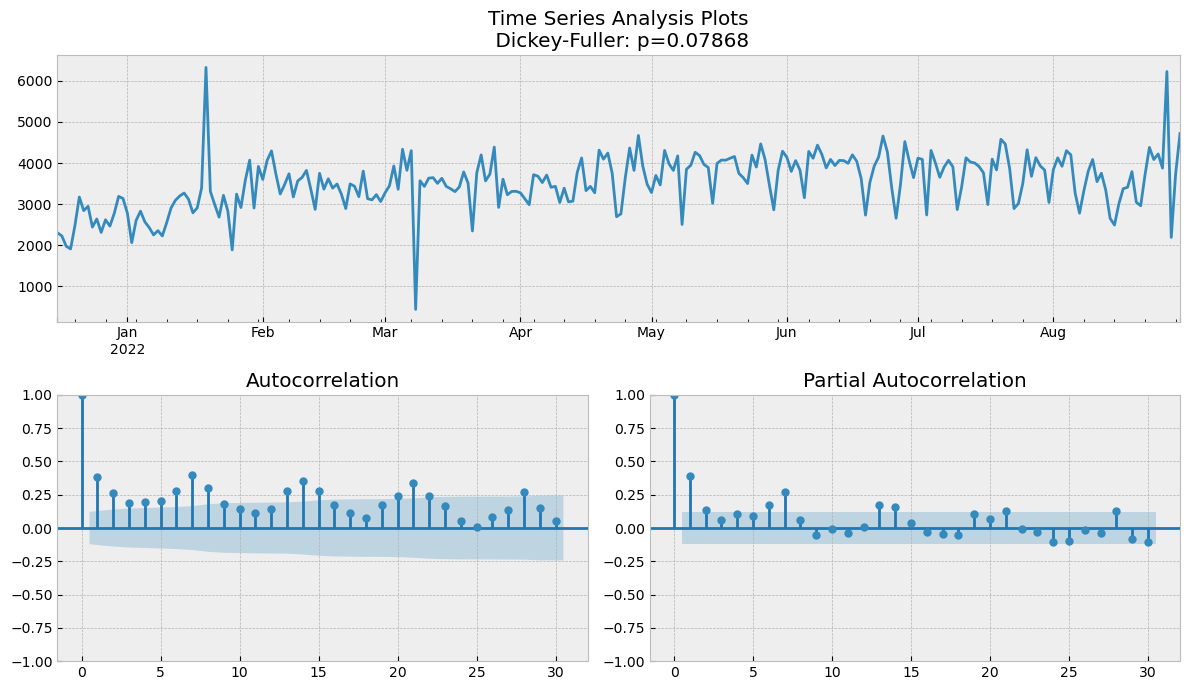

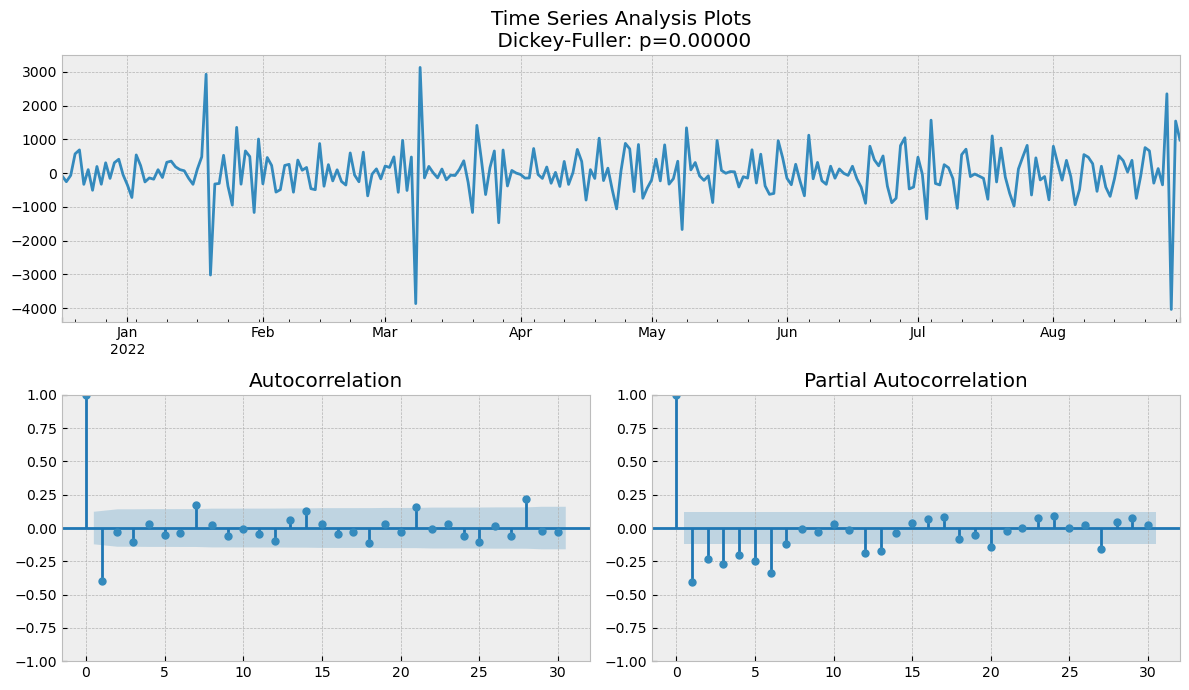

In [10]:
plt.clf()
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()


tsplot(var, lags=30)

# Take the first difference to remove to make the process stationary
tsplot(var.diff()[1:], lags=30)
# tsplot(np.sqrt(var).diff()[1:], lags=30)

In [16]:
# var_diff = var.diff()[1:]
# result_kpss_ct = sm.tsa.stattools.kpss(var_diff, regression="ct")
# print('Test Statistic: %f' % result_kpss_ct[0])
# print('p-value: %f' % result_kpss_ct[1])
# print('Critical values:')
# for key, value in result_kpss_ct[3].items():
#     print('\t%s: %.3f' % (key, value))

In [17]:
# result_kpss_ct_log = sm.tsa.stattools.kpss(np.sqrt(var).diff(7)[7:], regression="ct")
# print('Test Statistic: %f' % np.round(result_kpss_ct_log[0],2))
# print('p-value: %f' % result_kpss_ct_log[1])
# print('Critical values:')
# for key, value in result_kpss_ct_log[3].items():
#     print('\t%s: %.3f' % (key, value))

Null Hypothesis Can't be rejected -> Stationary

In [18]:
# p_value = sm.tsa.stattools.adfuller(var_diff)[1]
# print('Dickey-Fuller: p={0:.5f}'.format(p_value))

Null Hypothesis Strong Evidence for Rejecting H0 -> Stationary

In [19]:
# def split_timeseries(ts, lookbehind=None, test_pct=0.1):
#     ts_len = len(ts)
#     ts_test = ts[-int(test_pct * ts_len):]
#     ts_train = ts[:int((1-test_pct) * ts_len)]

#     if type(lookbehind) == float:
#         ts_train = ts_train[-int(lookbehind*len(ts_train)):]
#     elif type(lookbehind) == int:
#         ts_train = ts_train[-lookbehind:]
#     elif type(lookbehind) == str:
#         lookbehind = int(lookbehind)
#         ts_train = ts_train[ts_test.index[0] - pd.DateOffset(weeks=lookbehind, days=1):ts_test.index[0] - pd.DateOffset(days=1)]
#     return ts_train, ts_test


# train_var, test_var = split_timeseries(var, lookbehind=None)

In [20]:
# # Set initial values and some bounds
# ps = range(0, 5)
# d = 1
# qs = range(0, 5)
# Ps = range(0, 5)
# D = 1
# Qs = range(0, 5)
# s = 5

# # Create a list with all possible combinations of parameters
# parameters = product(ps, qs, Ps, Qs)
# parameters_list = list(parameters)
# len(parameters_list)


# # Train many SARIMA models to find the best set of parameters
# def optimize_SARIMA(ts, parameters_list, d, D, s):
#     """
#         Return dataframe with parameters and corresponding AIC

#         parameters_list - list with (p, q, P, Q) tuples
#         d - integration order
#         D - seasonal integration order
#         s - length of season
#     """

#     results = []
#     best_aic = float('inf')

#     for i, param in enumerate(parameters_list):
#         try:
#             model = sm.tsa.statespace.SARIMAX(
#                 ts, order=(param[0], d, param[1]),
#                 seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
#         except:
#             continue

#         aic = model.aic
#         # Save best model, AIC and parameters
#         if aic < best_aic:
#             best_model = model
#             best_aic = aic
#             best_param = param
#         results.append([param, model.aic])
#         print(i)

#     result_table = pd.DataFrame(results)
#     result_table.columns = ['parameters', 'aic']
#     # Sort in ascending order, lower AIC is better
#     result_table = result_table.sort_values(by='aic', ascending=True) \
#         .reset_index(drop=True)

#     return result_table


# # result_table = optimize_SARIMA(train_var, parameters_list, d, D, s)

# # Set parameters that give the lowest AIC (Akaike Information Criteria)
# p, q, P, Q = result_table.parameters[0]

# # best_model = sm.tsa.statespace.SARIMAX(
# #     train_var, order=(p, d, q), seasonal_order=(P, D, Q, s)).fit()

# best_model = sm.tsa.statespace.SARIMAX(
#     train_var, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit(disp=False)
# print(best_model.summary())

In [21]:
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

In [22]:
def sarima_configs(seasonal=[0, 7]):
    models = list()
    # define config lists
    p_params = [1, 2, 3, 4]  # Autoregressive
    d_params = [1]  # Difference
    q_params = [1, 2, 3, 4]  # ΜΑ
    t_params = ['n','c','t']
    P_params = [0, 1, 2, 7]
    D_params = [1]
    Q_params = [0, 1, 2, 7]
    m_params = seasonal
    # create config instances

    parameters = list(product(p_params, d_params, q_params, P_params, D_params, Q_params, m_params, t_params))
    for p in parameters:
        models.append([(p[0],p[1],p[2]), (p[3],p[4],p[5],p[6]),p[7]])
    return models

In [23]:
from math import sqrt

def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [76]:
def sarima_forecast(history, config):
    order, sorder, trend = config
    # define & fit model
    model = sm.tsa.statespace.SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
    # make one step forecast
    yhat = model.predict(len(history), len(history))
    return yhat[0], model.aic

In [77]:
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        print('pred')
        # fit model and make forecast for history
        yhat, aic = sarima_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    return aic, error, test, predictions

In [78]:
def score_model(data, n_test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                warnings.filterwarnings("ignore")
                aic, error, test, predictions = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
            aic = None
    # check for an interesting result
    if aic is not None:
        key = cfg
        print(' > Model[%s] %.3f' % (key, error))
        with open('modelsAIC_noenforce.out', 'a') as f:
            f.write(f'{key[0][0]},{key[0][1]},{key[0][2]},{key[1][0]},{key[1][1]},{key[1][2]},{key[1][3]},{key[2]},{aic:.3f},{error:.3f}\n')
    return (key, aic, error, test, predictions)

In [79]:
def grid_search(data, cfg_list, n_test, parallel=True):
    scores = None
    if parallel:      
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='loky')
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

In [80]:
# cfg_list = sarima_configs()
# # grid search
# scores = grid_search(var_diff, cfg_list, 12, True)
# print('done')
# # list top 3 configs
# for cfg, error in scores[:3]:
#     print(cfg, error)

In [82]:
# train, test = train_test_split(var.diff()[1:], 12)
# history = [x for x in train]
# model = sm.tsa.statespace.SARIMAX(history, order=(1,1,4), seasonal_order=(2,1,7,7), trend='n', enforce_stationarity=True, enforce_invertibility=True).fit(disp=False)
_, _, _, test, pred = score_model(var.diff()[1:].values, 12, [(2,1,1), (7,1,0,7), 't'])

pred
pred
pred
pred
pred
pred
pred
pred
pred
pred
pred
pred
 > Model[[(2, 1, 1), (7, 1, 0, 7), 't']] 513.486


In [ ]:
# measure_rmse(test, model.predict(len(train), len(train)+11))

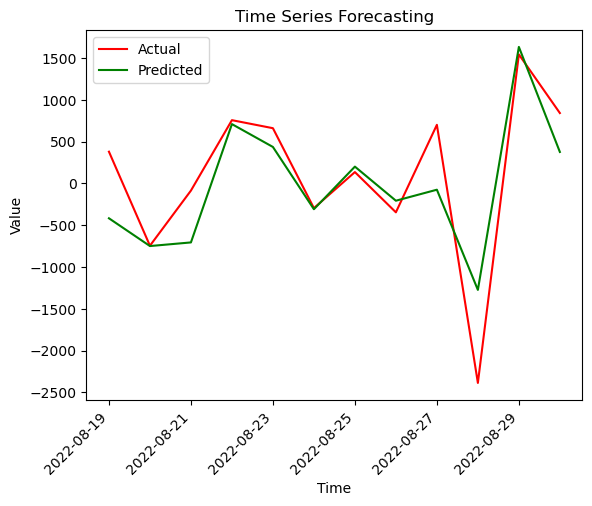

In [91]:
train, bb = train_test_split(var.diff()[1:], 12)
fig, ax = plt.subplots()
ax.set_xlabel('Time')
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)
ax.set_ylabel('Value')
ax.set_title('Time Series Forecasting')
ax.plot(bb.index, test, color='red', label='Actual')
ax.plot(bb.index, pred, color='green', label='Predicted')
ax.legend()